In [1]:
from fastai.text import *
from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback
from fastai.callbacks.tracker import ReduceLROnPlateauCallback

import fastai
print("Used fastai and torch version:")
print(fastai.__version__, torch.__version__)

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import pandas as pd

#torch.cuda.set_device(1) # torch.cuda.empty_cache()
path = Path("../out/Exp_04_02_corpus_small_60k")
print("\n")

print("=================================")
print("Reading in Train/valid/test data:")
print("==================================")
train_df = pd.read_json('../data/02_corpus/train.jsonl', lines=True)
valid_df = pd.read_json('../data/02_corpus/valid.jsonl', lines=True)
test_df = pd.read_json('../data/02_corpus/test.jsonl', lines=True)

lm_corpus = pd.read_json("../data/02_corpus/02_fuzzy_matched_corpus.jsonl", lines=True)

print("Shape of train: " + str(train_df.shape) + 
      ", valid: " + str(valid_df.shape) + 
      ", test: " + str(test_df.shape) + 
      ", LM corpus: " + str(lm_corpus.shape))

train_df.head()

Used fastai and torch version:
1.0.39 1.0.0


Reading in Train/valid/test data:
Shape of train: (963, 2), valid: (277, 2), test: (137, 2), LM corpus: (1377, 2)


,fulltext,rm
0,Association for Information Systems AIS Electr...,[Survey]
1,Association for Information Systems AIS Electr...,[Case Study]
2,SPECIAL ISSUE: SERVICE INNOVATION IN THE DIGIT...,[Case Study]
3,Association for Information Systems AIS Electr...,"[Literature Review, Opinion]"
4,chain scorecard Jong Han Park Jae Kyu Lee and ...,"[Conceptual, Case Study]"


In [2]:
lm_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1377 entries, 0 to 1376
Data columns (total 2 columns):
fulltext    1377 non-null object
rm          1377 non-null object
dtypes: object(2)
memory usage: 21.6+ KB


In [3]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [4]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)

## Data

In [5]:
lm_train, lm_valid = train_test_split(lm_corpus, 
                                      test_size = 0.05, 
                                      random_state = 0)

print("Number of rows in train: " + str(len(lm_train)) + 
      ", valid: " + str(len(lm_valid)))

Number of rows in train: 1308, valid: 69


In [6]:
data_lm = TextLMDataBunch.from_df(path, 
                                  lm_train, 
                                  lm_valid, 
                                  bs=48, 
                                  text_cols = 'fulltext',
                                  max_vocab = 60000, 
                                  min_freq = 2)
data_lm.save('data_lm')
print(f"Language model vocab size: {len(data_lm.vocab.itos)}")
print(f"data_lm saved to: {path}")

Language model vocab size: 54930
data_lm saved to: ../out/Exp_04_02_corpus_small_60k


In [7]:
data_classifier = TextClasDataBunch.from_df(path, 
                                            train_df, 
                                            valid_df, 
                                            test_df, 
                                            bs=64, 
                                            max_vocab = 60000, 
                                            min_freq = 2, 
                                            vocab = data_lm.train_ds.vocab,
                                            text_cols = 'fulltext', 
                                            label_cols ='rm')
data_classifier.save('data_classifier')

print(f"Classifier vocab size: {len(data_classifier.vocab.itos)}.")
print(f"data_classifier saved to: {path}")

Classifier vocab size: 54930.
data_classifier saved to: ../out/Exp_04_02_corpus_small_60k


In [8]:
# data_lm.vocab.stoi
# Output:
# defaultdict(int,
#             {'xxunk': 0,
#              'xxpad': 1,
#              'xxbos': 2,
#              'xxfld': 3,
#              'xxmaj': 4,
#              'xxup': 5,
#              'xxrep': 6,
#              'xxwrep': 7,
#              ',': 8,
#              '.': 9,
#              'the': 10,
#              'of': 11,
#              'and': 12,

In [9]:
# data_classifier.vocab.stoi
# defaultdict(int,
#             {'xxunk': 0,
#              'xxpad': 1,
#              'xxbos': 2,
#              'xxfld': 3,
#              'xxmaj': 4,
#              'xxup': 5,
#              'xxrep': 6,
#              'xxwrep': 7,
#              ',': 8,
#              '.': 9,
#              'the': 10,
#              'of': 11,
#              'and': 12,

In [10]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj association for xxmaj information xxmaj systems xxup ais xxmaj electronic xxmaj library aisel xxup ecis xxmaj completed xxmaj research xxmaj papers xxup ecis xxmaj proceedings xxmaj spring xxmaj can xxmaj target xxmaj costing xxmaj be xxmaj applied in xxmaj green xxmaj logistics ? xxmaj evidence from a xxmaj conjoint xxmaj analysis xxmaj volker xxmaj frehe xxmaj osnabrueck xxmaj university , xxmaj follow this and additional works at :"
1,"breach function . xxmaj basically , what drives their result is the relative size of the firm marginal benefit from an additional dollar of information security expenditure , at different levels of security investment . galor and xxmaj ghose : xxmaj the xxmaj economic xxmaj incentives for xxmaj sharing xxmaj security xxmaj information xxmaj implications , xxmaj conclusion , and xxmaj extensions xxmaj the xxup u.s. federal government has encouraged"
2,", they can be counted towards digital markets . xxmaj in line with prior acceptance research xxcite , we thus contend a second hypothesis : h : xxmaj the perceived risk of offering one own car in xxup pp carsharing services negatively influences the intention to use a xxup pp carsharing service . xxmaj in addition , if the perceived risk of offering one own car in xxup pp carsharing"
3,"guide for creating new measures in xxup mis and other disciplines . xxmaj we believe it can enhance the capabilities of researchers aiming to add to the existing body of knowledge by developing quality instruments to measure relevant constructs . xxmaj further , we anticipate that widespread use of this method can expedite advancements in sciences striving to reach the normal state articulated by xxcite . xxmaj about the authors"
4,"a number of previously validated survey instruments for example see xxcite ; xxmaj fogarty et xxunk the space limitations we present results for only a few of the questions / statements . xxmaj these are : xxmaj questions requiring a xxmaj yes / xxmaj no response xxmaj did you enjoy being in xxmaj digital xxmaj divas ? , xxmaj has your confidence with computers improved ? , xxmaj have your"


In [11]:
data_classifier.show_batch()

text,target
"xxbos xxmaj association for xxmaj information xxmaj systems xxup ais xxmaj electronic xxmaj library aisel xxup icis xxmaj proceedings xxmaj international xxmaj conference on xxmaj information xxmaj systems xxup icis xxmaj strategic xxmaj choices in xxup is xxmaj infrastructure : xxmaj corporate xxmaj standards xxmaj versus "" xxmaj best of xxmaj breed "" xxmaj systems xxmaj rajiv xxmaj dewan xxmaj university of xxmaj rochester xxmaj abraham xxmaj seidmann xxmaj university",Literature Review;Survey
"xxbos xxup research xxup article xxup information xxup technology xxup impacts xxup on xxup firm xxup performance : xxup an xxup extension xxup of xxcite xxmaj rajiv xxmaj sabherwal xxmaj department of xxmaj information xxmaj systems , xxmaj sam xxup m. xxmaj walton xxmaj college of xxmaj business , xxmaj university of xxmaj arkansas , xxmaj north xxunk xxmaj avenue , xxmaj fayetteville , xxup ar xxup u.s.a. xxmaj anand",Conceptual;Literature Analysis
"xxbos xxup research xxup article xxup mobile xxup application xxup usability : xxup conceptualization xxup and xxup instrument xxup development xxmaj hartmut xxmaj hoehle and xxmaj viswanath xxmaj venkatesh xxmaj department of xxmaj information xxmaj systems , xxmaj sam xxup m. xxmaj walton xxmaj college of xxmaj business , xxmaj university of xxmaj arkansas , xxmaj fayetteville , xxup ar xxup u.s.a. xxmaj this paper presents a mobile application usability",Other
xxbos xxmaj zhang and xxmaj li / xxmaj intellectual xxmaj development of xxup hci xxmaj research xxup is xxup research xxup perspectives xxup article xxmaj the xxmaj intellectual xxmaj development of humancomputer xxmaj interaction xxmaj research : a xxmaj critical xxmaj assessment of the xxup mis xxmaj literature xxmaj ping xxmaj zhang xxmaj school of xxmaj information xxmaj studies xxmaj syracuse xxmaj university xxmaj na xxmaj xxunk xxmaj li xxmaj,Literature Analysis;Literature Review
"xxbos xxmaj continuance xxmaj model xxup misc to xxmaj better xxmaj explain enduser xxmaj system xxmaj evaluations and xxmaj continuance xxmaj intentions xxmaj paul xxmaj benjamin xxmaj lowry xxmaj city xxmaj university of xxmaj hong xxmaj kong xxmaj james xxmaj eric xxmaj gaskin xxmaj brigham xxmaj young xxmaj university xxmaj gregory xxup d. xxmaj moody xxmaj university of xxmaj nevada , xxmaj las xxmaj vegas xxmaj abstract xxmaj to ensure",Conceptual;Experiment


## LM

In [12]:
save_model = partial(SaveModelCallback, 
                     monitor='accuracy', 
                     every='improvement', 
                     name='best_lm')

early_stop = partial(EarlyStoppingCallback,
                     monitor='val_loss', 
                     min_delta=0.01, 
                     patience=2)

# bptt = 70, emb_sz = 400, nh = 1150, nl = 3, drop_mult = 1, wd = 0, 
lm_learner = language_model_learner(data_lm, 
                                    pretrained_model = URLs.WT103_1, 
                                    drop_mult = 0.3,
                                    callback_fns = [save_model, early_stop])

print("Summary of the model's structure:")
print("=================================")
print(lm_learner.model) # summary

Summary of the model's structure:
SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(54930, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(54930, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=54930, bias=True)
    (output_dp): RNNDropout()
  )
)


Train Learner over a few iterations. 
- Start with a very low `start_lr` and change it at each mini-batch until it reaches a very high `end_lr`. 
- Recorder will **record the loss at each iteration**. 
- Plot those losses against the learning rate to **find the optimal value before it diverges**.



In [13]:
lm_learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


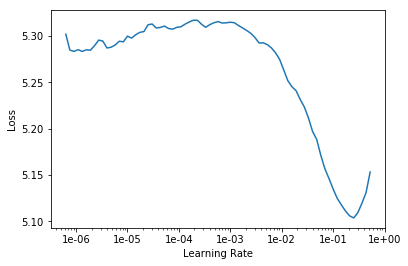

In [14]:
lm_learner.recorder.plot(skip_end=15) 
# default: plot(`skip_start`:int=`10`, `skip_end`:int=`5`)

## Classifier

In [15]:
print("Define the model for the target task, i.e. Classification")

save_1 = partial(SaveModelCallback, 
                 monitor = 'accuracy_thresh', 
                 every = 'improvement', 
                 name = 'best_accuracy_classifier')

save_2 = partial(SaveModelCallback, 
                 monitor = 'fbeta', 
                 every = 'improvement', 
                 name = 'best_fbeta_classifier')

early_stop = partial(EarlyStoppingCallback, 
                     monitor ='val_loss', 
                     min_delta = 0.005, 
                     patience = 3)

lr_schedule = partial(ReduceLROnPlateauCallback, 
                      monitor = 'val_loss', 
                      patience = 2, 
                      factor = 0.1, 
                      min_delta = 0.005)

# bptt = 70, emb_sz = 400, nh = 1150, nl = 3, drop_mult = 1, wd = 0, 
classifier_learner = text_classifier_learner(data_classifier, drop_mult=0.5,
                                     callback_fns = [save_1, save_2, early_stop, lr_schedule],
                                     metrics = [accuracy_thresh, fbeta])
print("Classifier defined. \n Model's summary:")
print("=======================================")
print(classifier_learner.model) # summary

Define the model for the target task, i.e. Classification
Classifier defined. 
 Model's summary:
SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(54930, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(54930, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d

In [16]:
classifier_learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


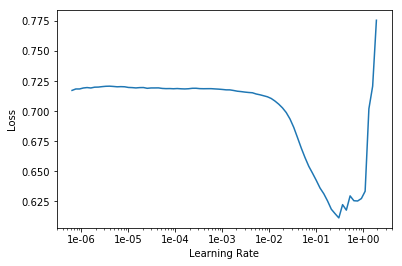

In [17]:
classifier_learner.recorder.plot(skip_end=5)

### LM Head

In [19]:
# torch.cuda.empty_cache()
print("Train only the last layer of the LM with a large LR:")
print("====================================================")
lm_learner.freeze_to(-1)
lm_learner.fit_one_cycle(cyc_len = 1, 
                         max_lr = 5e-2, 
                         moms = (0.8, 0.7))
# epoch	train_loss	valid_loss	accuracy
# 1	4.334761	3.987179	0.343920

Train only the last layer of the LM with a large LR:


epoch,train_loss,valid_loss,accuracy
1,4.710644,4.402639,0.309722


In [20]:
# only last layer trained so far
lm_learner.save('lm_head')

### LM tune further

In [21]:
lm_learner.load('lm_head')
lm_learner.freeze_to(-2)
lm_learner.fit_one_cycle(2, max_lr = 1e-2, moms = (0.8, 0.7))
# Total time: 3:36:26
#epoch	train_loss	valid_loss	accuracy
# 1 	3.875191	4.073611	0.342777
# 2 	3.753567	3.906425	0.357417
# 3 	3.892894	3.714304	0.376911

epoch,train_loss,valid_loss,accuracy
1,4.031379,4.079500,0.340390
2,4.009102,3.842782,0.364275


In [22]:
lm_learner.save('lm_2_last_layers_tuned')

### LM: unfreeze entire model

In [23]:
print("Unfreeze entire model. Train with Discriminative LRs. " + 
      "Set every layer group to trainable (i.e. requires_grad=True).")
print("=============================================================")
lm_learner.load('lm_2_last_layers_tuned')
lm_learner.unfreeze()
lm_learner.fit_one_cycle(cyc_len = 3, 
                         max_lr = slice(1e-5, 1e-3), 
                         moms = (0.8, 0.7))
# epoch	train_loss	valid_loss	accuracy
#1	3.563736	3.798236	0.369602

Unfreeze entire model. Train with Discriminative LRs. Set every layer group to trainable (i.e. requires_grad=True).


epoch,train_loss,valid_loss,accuracy
1,3.758345,3.826353,0.366662
2,3.769183,3.794012,0.369719
3,3.660429,3.786516,0.370959


In [24]:
lm_learner.save('lm_all_layers_finetuned')
lm_learner.save_encoder('lm_encoder')

In [25]:
print(lm_learner.predict('Therefore, in this paper, ', 300, temperature = 0.75, min_p = 0.001))

Therefore, in this paper,  we develop our hypotheses about the relationship between perceived value and perceived enjoyment to the xxup it artifact . xxmaj drawing on the xxmaj theory of xxmaj planned xxmaj behavior , we conceptualize the relationship between two key drivers of xxup it experience by describing the relationship between customer and xxup it system value . xxmaj in our work , we propose that xxup it refers to the individual characteristics of the system , i.e. , its internal entities and their behavior . xxmaj we focus on the xxup it function in which the human activity influences xxup it identity . xxmaj we present our study with a set of hypotheses , including the xxup it artifact , the xxup it artifact , and its impact on the xxup it artifact . xxmaj we propose a model of xxup it value management and highlight how a xxup it xxmaj human xxmaj resource xxmaj environment xxmaj we were able to solve a problem when the xxup it identity is considered to be the core of the sy

Plotting loss, metrics, LR & Momentums for the Language Model trained on entire IS Corpus:


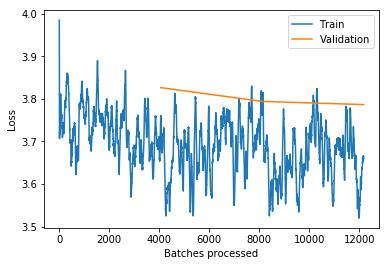

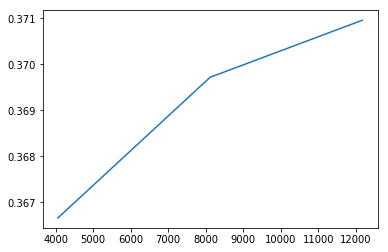

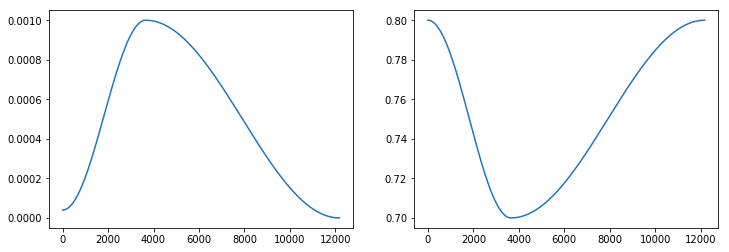

In [26]:
print("==========================================================================================")
print("Plotting loss, metrics, LR & Momentums for the Language Model trained on entire IS Corpus:")
lm_learner.recorder.plot_losses()
lm_learner.recorder.plot_metrics()
lm_learner.recorder.plot_lr(show_moms=True)

### Classifier head

In [27]:
classifier_learner.load_encoder('lm_encoder')
classifier_learner.freeze()
classifier_learner.fit_one_cycle(3, 5e-2, moms=(0.8, 0.7))
# epoch 	train_loss	valid_loss	accuracy_thresh	fbeta
#     10	0.246892	0.255884	0.893429	0.634295

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.444347,0.270760,0.889290,0.557172
2,0.333425,0.252731,0.897714,0.598546
3,0.287532,0.253162,0.899398,0.603896


In [28]:
classifier_learner.save('classifier_last_layer_tuned')

Plotting loss for Multlabel Classifier:


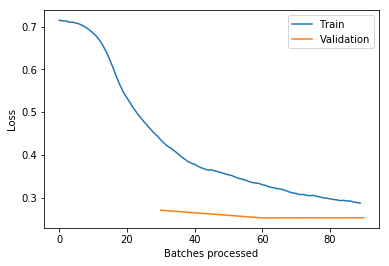

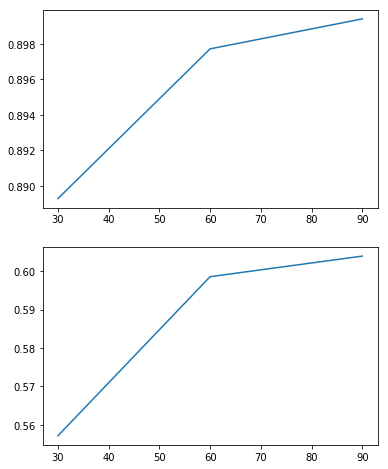

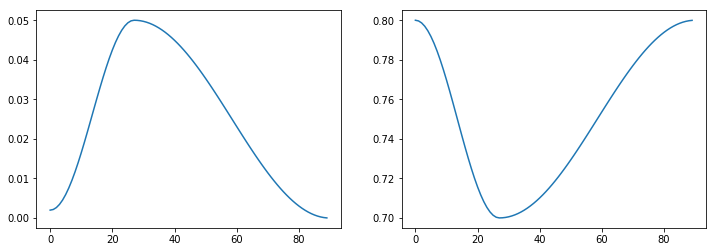

In [29]:
print("===============================================================================================")
print("Plotting loss for Multlabel Classifier:")
classifier_learner.recorder.plot_losses()
classifier_learner.recorder.plot_metrics()
classifier_learner.recorder.plot_lr(show_moms=True)

## Further fine tuning

In [30]:
classifier_learner.load("classifier_last_layer_tuned")
classifier_learner.freeze_to(-2)
classifier_learner.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))
# epoch	train_loss	valid_loss	accuracy_thresh	fbeta
# 8	0.265795	0.265270	0.887714	0.658705

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.247804,0.250058,0.902527,0.616844


In [31]:
classifier_learner.save('classifier_two_last_layers_tuned')

In [32]:
classifier_learner.load('classifier_two_last_layers_tuned')
classifier_learner.unfreeze()
classifier_learner.fit_one_cycle(3, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.235196,0.249074,0.905415,0.610519
2,0.234234,0.246185,0.906619,0.611909
3,0.232787,0.247907,0.903490,0.611584


In [33]:
classifier_learner.save('classifier_all_layers_finetuned')

Plotting loss, metrics, LR & Momentums for Multlabel Classifier trained on full text of papers:


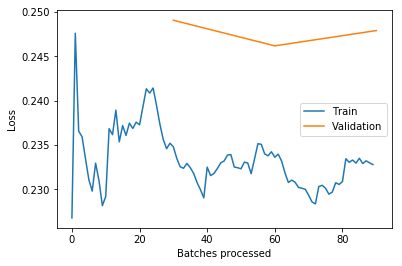

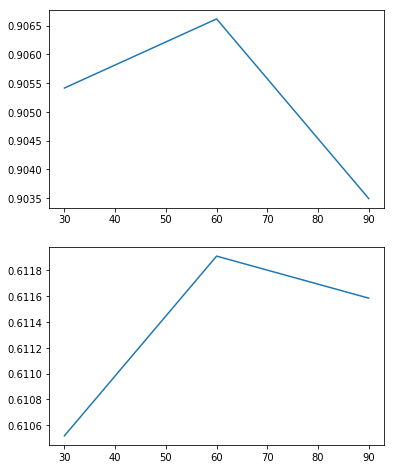

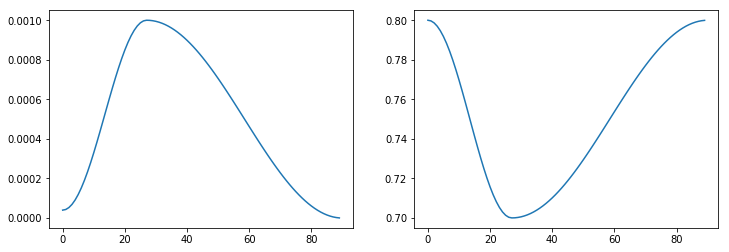

In [34]:
print("===============================================================================================")
print("Plotting loss, metrics, LR & Momentums for Multlabel Classifier trained on full text of papers:")
classifier_learner.recorder.plot_losses()
classifier_learner.recorder.plot_metrics()
classifier_learner.recorder.plot_lr(show_moms=True)

In [35]:
classifier_learner.load("classifier_all_layers_finetuned")

y_pred, y_true = classifier_learner.get_preds(ds_type = DatasetType.Train, with_loss=False)

threshold = 0.5
y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

classifier_metrics = {}
classifier_metrics.update({'precision':skm.precision_score(y_true,
                                                           y_pred,
                                                           average='micro')})

classifier_metrics.update({'recall':skm.recall_score(y_true,
                                                     y_pred,
                                                     average='micro')})

classifier_metrics.update({'f1_measure':skm.f1_score(y_true,
                                                          y_pred,
                                                          average='micro')})

classifier_metrics.update({'fbeta_score':skm.fbeta_score(y_true,
                                                        y_pred,
                                                         beta=2,
                                                          average='micro')})

classifier_metrics.update({'hamming_loss':skm.hamming_loss(y_true,
                                                           y_pred)})

classifier_metrics.update({'exact_match':skm.accuracy_score(y_true,
                                                            y_pred)})

classifier_metrics_train_df = pd.DataFrame.from_dict(data = classifier_metrics,
                                                 orient='index',
                                                 columns=['train'])

#________________________________________________________________________________

y_pred, y_true = classifier_learner.get_preds(ds_type = DatasetType.Valid, with_loss=False)

y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

classifier_metrics = {}
classifier_metrics.update({'precision':skm.precision_score(y_true,
                                                           y_pred,
                                                           average='micro')})

classifier_metrics.update({'recall':skm.recall_score(y_true,
                                                     y_pred,
                                                     average='micro')})

classifier_metrics.update({'f1_measure':skm.f1_score(y_true,
                                                          y_pred,
                                                          average='micro')})

classifier_metrics.update({'fbeta_score':skm.fbeta_score(y_true,
                                                        y_pred,
                                                         beta=2,
                                                          average='micro')})

classifier_metrics.update({'hamming_loss':skm.hamming_loss(y_true,
                                                           y_pred)})

classifier_metrics.update({'exact_match':skm.accuracy_score(y_true,
                                                            y_pred)})

classifier_metrics_valid_df = pd.DataFrame.from_dict(data = classifier_metrics,
                                                 orient='index',
                                                 columns=['valid'])
#____________________________________________________________________________________

y_pred, y_true = classifier_learner.get_preds(ds_type = DatasetType.Test, with_loss=False)

print("Predictions generated.")
print("====================")
print("Evaluation metrics on the train, valid and test set:")

y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

classifier_metrics = {}
classifier_metrics.update({'precision':skm.precision_score(y_true,
                                                           y_pred,
                                                           average='micro')})

classifier_metrics.update({'recall':skm.recall_score(y_true,
                                                     y_pred,
                                                     average='micro')})

classifier_metrics.update({'f1_measure':skm.f1_score(y_true,
                                                          y_pred,
                                                          average='micro')})

classifier_metrics.update({'fbeta_score':skm.fbeta_score(y_true,
                                                        y_pred,
                                                         beta=2,
                                                          average='micro')})

classifier_metrics.update({'hamming_loss':skm.hamming_loss(y_true,
                                                           y_pred)})

classifier_metrics.update({'exact_match':skm.accuracy_score(y_true,
                                                            y_pred)})

classifier_metrics_test_df = pd.DataFrame.from_dict(data = classifier_metrics,
                                                 orient='index',
                                                 columns=['test'])
#____________________________________________________________________________________

results = pd.concat(objs = [classifier_metrics_train_df,
                            classifier_metrics_valid_df,
                            classifier_metrics_test_df], axis = 1)
results.to_csv("../out/Exp_04_02_corpus_small_60k/exp_04_metrics_all_layers_finetuned.csv",
                               index=False,
                               header=True)
results

Predictions generated.
Evaluation metrics on the train, valid and test set:


,train,valid,test
precision,0.708688,0.680672,0.151316
recall,0.485131,0.470019,0.167883
f1_measure,0.575978,0.556064,0.159170
fbeta_score,0.517799,0.501031,0.164286
hamming_loss,0.085069,0.093381,0.118248
exact_match,0.260417,0.259928,0.043796


In [36]:
classifier_learner.load('classifier_all_layers_finetuned')
classifier_learner.unfreeze()
classifier_learner.fit_one_cycle(3, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7)) # get_preds(DatasetType.Fix, ordered=True)
# sigmoid=False
# 3	0.203966	0.231896	0.908063	0.673956

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.236122,0.247346,0.899158,0.615130
2,0.233480,0.246305,0.901324,0.626127
3,0.224865,0.247435,0.901083,0.626851


In [37]:
classifier_learner.save('classifier_all_layers_finetuned_longer')

In [38]:
classifier_learner.load("classifier_all_layers_finetuned_longer")

y_pred, y_true = classifier_learner.get_preds(ds_type = DatasetType.Train, with_loss=False)

threshold = 0.5
y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

classifier_metrics = {}
classifier_metrics.update({'precision':skm.precision_score(y_true,
                                                           y_pred,
                                                           average='micro')})

classifier_metrics.update({'recall':skm.recall_score(y_true,
                                                     y_pred,
                                                     average='micro')})

classifier_metrics.update({'f1_measure':skm.f1_score(y_true,
                                                          y_pred,
                                                          average='micro')})

classifier_metrics.update({'fbeta_score':skm.fbeta_score(y_true,
                                                        y_pred,
                                                         beta=2,
                                                          average='micro')})

classifier_metrics.update({'hamming_loss':skm.hamming_loss(y_true,
                                                           y_pred)})

classifier_metrics.update({'exact_match':skm.accuracy_score(y_true,
                                                            y_pred)})

classifier_metrics_train_df = pd.DataFrame.from_dict(data = classifier_metrics,
                                                 orient='index',
                                                 columns=['train'])

#________________________________________________________________________________

y_pred, y_true = classifier_learner.get_preds(ds_type = DatasetType.Valid, with_loss=False)

y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

classifier_metrics = {}
classifier_metrics.update({'precision':skm.precision_score(y_true,
                                                           y_pred,
                                                           average='micro')})

classifier_metrics.update({'recall':skm.recall_score(y_true,
                                                     y_pred,
                                                     average='micro')})

classifier_metrics.update({'f1_measure':skm.f1_score(y_true,
                                                          y_pred,
                                                          average='micro')})

classifier_metrics.update({'fbeta_score':skm.fbeta_score(y_true,
                                                        y_pred,
                                                         beta=2,
                                                          average='micro')})

classifier_metrics.update({'hamming_loss':skm.hamming_loss(y_true,
                                                           y_pred)})

classifier_metrics.update({'exact_match':skm.accuracy_score(y_true,
                                                            y_pred)})

classifier_metrics_valid_df = pd.DataFrame.from_dict(data = classifier_metrics,
                                                 orient='index',
                                                 columns=['valid'])
#____________________________________________________________________________________

y_pred, y_true = classifier_learner.get_preds(ds_type = DatasetType.Test, with_loss=False)

print("Predictions generated.")
print("====================")
print("Evaluation metrics on the train, valid and test set:")

y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

classifier_metrics = {}
classifier_metrics.update({'precision':skm.precision_score(y_true,
                                                           y_pred,
                                                           average='micro')})

classifier_metrics.update({'recall':skm.recall_score(y_true,
                                                     y_pred,
                                                     average='micro')})

classifier_metrics.update({'f1_measure':skm.f1_score(y_true,
                                                          y_pred,
                                                          average='micro')})

classifier_metrics.update({'fbeta_score':skm.fbeta_score(y_true,
                                                        y_pred,
                                                         beta=2,
                                                          average='micro')})

classifier_metrics.update({'hamming_loss':skm.hamming_loss(y_true,
                                                           y_pred)})

classifier_metrics.update({'exact_match':skm.accuracy_score(y_true,
                                                            y_pred)})

classifier_metrics_test_df = pd.DataFrame.from_dict(data = classifier_metrics,
                                                 orient='index',
                                                 columns=['test'])
#____________________________________________________________________________________

results = pd.concat(objs = [classifier_metrics_train_df,
                            classifier_metrics_valid_df,
                            classifier_metrics_test_df], axis = 1)
results.to_csv("../out/Exp_04_02_corpus_small_60k/exp_04_metrics_all_layers_tuned_longer.csv",
                               index=False,
                               header=True)
results

Predictions generated.
Evaluation metrics on the train, valid and test set:


,train,valid,test
precision,0.708397,0.635897,0.140244
recall,0.540793,0.479691,0.167883
f1_measure,0.613351,0.546858,0.152824
fbeta_score,0.567654,0.504475,0.161517
hamming_loss,0.081250,0.098917,0.124088
exact_match,0.296875,0.263538,0.043796
